# Infancias, vegetación y proximidad

This notebook plots population of the ages 0-5 (early childhood), NDVI vegetation categories and proximity analysis for a city.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Function definition

In [2]:
def create_maps(city_list, res, save):
    for city in city_list:
         
        print(f"Starting analysis for {city}")       
        
        #----------------------------------------- DOWNLOAD DATA -----------------------------------------
        # Download proximity analysis data
        prox_schema = 'prox_analysis'
        prox_table = 'proximityanalysis_20_ageb_hex8'
        query = f"SELECT * FROM {prox_schema}.{prox_table} WHERE \"city\" LIKE \'{city}\'"
        prox_gdf = aup.gdf_from_query(query, geometry_col='geometry')
        
        print(f"Downloaded proximity analysis data.")
        
        # Download NDVI data
        ndvi_schema = 'raster_analysis'
        ndvi_table = 'ndvi_analysis_hex'
        query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
        ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')
        
        print(f"Downloaded NDVI data.")
        
        # Download census 2020 data
        # Download cvgeos from municipalities
        mun_schema = 'metropolis'
        mun_table = 'metro_gdf'
        query = f"SELECT * FROM {mun_schema}.{mun_table} WHERE \"city\" LIKE \'{city}\'"
        mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
        cvegeo_list = list(mun_gdf.loc[mun_gdf.city==city]["CVEGEO"].unique())
        
        print(f"Downloaded municipalities data.")
        
        # Donwload hexagons with pop data iterating over municipality codes for each metropolitan area or capital
        hex_pop = gpd.GeoDataFrame()
        hex_schema = 'censo'
        hex_table = 'hex_bins_pop_2020'
        for cvegeo in cvegeo_list:
            # Downloads municipality polygon according to code
            query = f"SELECT * FROM {hex_schema}.{hex_table} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
            hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
            hex_pop = pd.concat([hex_pop, hex_tmp],
            ignore_index = True, axis = 0)
        
        print(f"Downloaded pop data.")
        
        #----------------------------------------- DATA TREATMENT -----------------------------------------
        # Calculate early childhood %
        hex_pop['p_infancia'] = hex_pop['p_0a2'] + hex_pop['p_3a5']
        hex_pop['pct_infancia'] = hex_pop['p_infancia'] / hex_pop['pobtot']
        
        # Create data categories for early childhood
        hex_pop['pct_inf_rango'] = np.nan
        hex_pop.loc[hex_pop.pct_infancia>=0.14 , 'pct_inf_rango'] = '+14%'
        hex_pop.loc[(hex_pop.pct_infancia>=0.12 )&
                     (hex_pop.pct_infancia<0.14), 'pct_inf_rango'] = '12% - 14%'
        hex_pop.loc[(hex_pop.pct_infancia>=0.10)&
                     (hex_pop.pct_infancia<0.12), 'pct_inf_rango'] = '10% - 12%'
        hex_pop.loc[(hex_pop.pct_infancia>=0.08)&
                     (hex_pop.pct_infancia<0.1), 'pct_inf_rango'] = '8% - 10%'
        hex_pop.loc[(hex_pop.pct_infancia>=0.06)&
                     (hex_pop.pct_infancia<0.08), 'pct_inf_rango'] = '6% - 8%'
        hex_pop.loc[(hex_pop.pct_infancia>=0.03)&
                     (hex_pop.pct_infancia<0.06), 'pct_inf_rango'] = '3% - 6%'
        hex_pop.loc[(hex_pop.pct_infancia<0.03), 'pct_inf_rango'] = '0% - 3%'
        #Definir orden y convertir pct_inf_rango en categoría ordenada
        categories = ['0% - 3%', '3% - 6%', '6% - 8%', '8% - 10%', '10% - 12%', '12% - 14%', '+14%']
        hex_pop['pct_inf_rango'] = pd.Categorical(hex_pop['pct_inf_rango'], categories=categories, ordered=True)
        
        # Create data categories for NDVI
        ndvi_gdf['ndvi_median_rango'] = np.nan
        ndvi_gdf.loc[ndvi_gdf.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.4 )&
                     (ndvi_gdf.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.2)&
                     (ndvi_gdf.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.1)&
                     (ndvi_gdf.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'
        #Definir orden y convertir pct_inf_rango en categoría ordenada
        categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
        ndvi_gdf['ndvi_median_rango'] = pd.Categorical(ndvi_gdf['ndvi_median_rango'], categories=categories, ordered=True)
        
        # Create data categories for proximity analysis
        prox_gdf['prox_cat'] = np.nan
        prox_gdf.loc[prox_gdf.max_idx_15_min>=60 , 'prox_cat'] = '>60'
        prox_gdf.loc[(prox_gdf.max_idx_15_min>=45 )&
                     (prox_gdf.max_idx_15_min<60), 'prox_cat'] = '45-60'
        prox_gdf.loc[(prox_gdf.max_idx_15_min>=30)&
                     (prox_gdf.max_idx_15_min<45), 'prox_cat'] = '30-45'
        prox_gdf.loc[(prox_gdf.max_idx_15_min>=15)&
                     (prox_gdf.max_idx_15_min<30), 'prox_cat'] = '15-30'
        prox_gdf.loc[(prox_gdf.max_idx_15_min<15), 'prox_cat'] = '<15'
        #Definir orden y convertir pct_inf_rango en categoría ordenada
        categories = ['<15', '15-30', '30-45', '45-60', '>60']
        prox_gdf['prox_cat'] = pd.Categorical(prox_gdf['prox_cat'], categories=categories, ordered=True)
        
        print(f"Created categorical data.")
        
        # Filter for ranges of interest
        prox_interest_gdf = prox_gdf.loc[(prox_gdf['prox_cat'] == '<15') | 
                                         (prox_gdf['prox_cat'] == '15-30')]

        # Redifine categorical order to avoid problems while plotting proximity data
        categories = ['15-30','<15']
        prox_interest_gdf['prox_cat'] = pd.Categorical(prox_interest_gdf['prox_cat'], categories=categories, ordered=True)

        # Dissolve data
        prox_interest_gdf.to_crs("EPSG:6372",inplace=True)
        dissolved = prox_interest_gdf.dissolve('prox_cat')
        dissolved.reset_index(inplace=True)
        dissolved.to_crs("EPSG:4326",inplace=True)
        
        print(f"Finished data treatment.")  
        
        #----------------------------------------- VISUALIZATION -----------------------------------------
        # Format - Colors
        colors = ["black","orange"]

        # Plot
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        # Plot - First map
        hex_pop.plot('pct_inf_rango', 'BuPu', ax=ax[0], legend=True,zorder=1)
        dissolved.plot('prox_cat',ax=ax[0],zorder=2,
                       edgecolor=colors,
                       facecolor="none",
                       lw=1)
        # Plot - Second map
        ndvi_gdf.plot('ndvi_median_rango','YlGn', ax=ax[1], legend=True,zorder=1)
        dissolved.plot('prox_cat',ax=ax[1],zorder=2,
                       edgecolor=colors,
                       facecolor="none",
                       lw=1)

        # Format - Axis titles
        ax[0].set_title('Porcentaje de población en edad de 0 - 5 años')
        ax[1].set_title('Índice de vegetación')
        
        print(f"Finished visualization for {city}.") 

        # Saving visualization
        if save:
            plt.savefig(save_dir+f"ndvi_infancia_prox_{city.lower()}.svg")
            
            print(f"Finished saving visualization.") 

## Run function

Starting analysis for ZMVM
Downloaded proximity analysis data.
Downloaded NDVI data.
Downloaded municipalities data.
Downloaded pop data.
Created categorical data.
Finished data treatment.


/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Finished visualization for ZMVM.
Finished saving visualization.


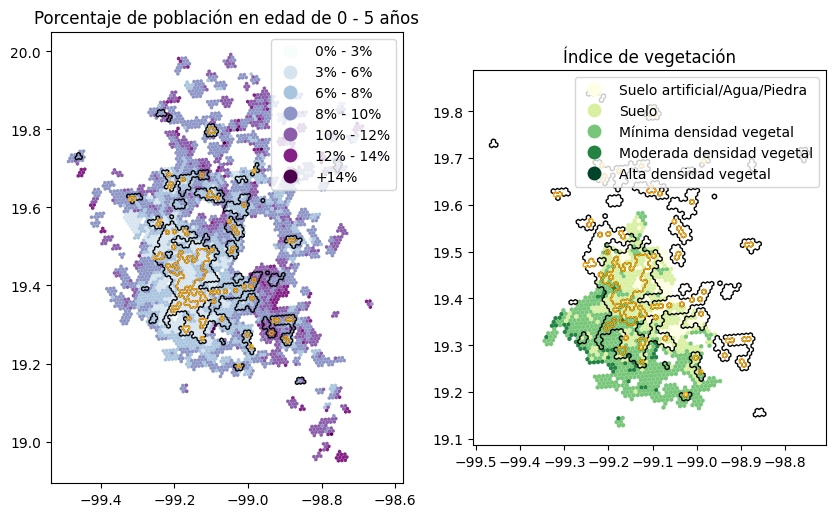

In [4]:
# City list to run:
city_list = ['ZMVM']

# If save, saves to:
save_dir = "../../../output/figures/ndvi_infancia/"

# Resolution of analysis: Resolutions 8,9,10,11 available for NDVI but pop0a5 only available in hex_bins_pop_2020, res=8 and (if not res=8)
# proximity analysis would have to be changed manually.
create_maps(city_list, res=8, save=True)